In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999

<h2>Data import</h2>

In [8]:
dca = pd.read_csv('../src/dca_291118.csv')

some EDA

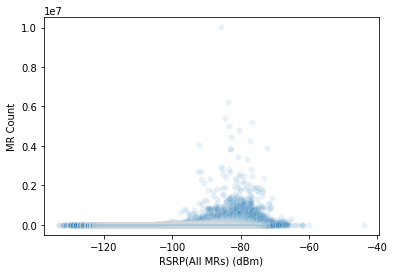

In [31]:
sns.scatterplot('RSRP(All MRs) (dBm)','MR Count',data=dca,alpha=0.1)

In [9]:
dla_1 = pd.read_csv('../src/LTE-FDD_traffic_Grid_2018113009523030927/LTE-FDD_traffic_Grid_2018113009523030927.csv')
dla_2 = pd.read_csv('../src/LTE-FDD_traffic_Grid_2018113009523030927/LTE-FDD_traffic_Grid_2018113009523030927_1.csv')

In [10]:
print(dla_1.shape)
print(dla_2.shape)

dla = pd.concat([dla_1,dla_2],axis=0)
del dla_1,dla_2

(1000000, 34)
(909860, 34)


In [7]:
dla = pd.concat([dla_1,dla_2],axis=0)
del dla_1,dla_2

In [9]:
dca.head()

,,RSRP(All MRs) (dBm),MR Count
Latitude,Longitude,,
14.269975,100.930211,-133.0,1
13.519042,100.480714,-133.0,1
14.150815,100.909358,-132.0,1
13.554116,100.918626,-132.0,1
14.225009,100.908895,-132.0,1


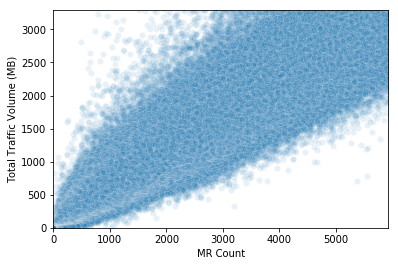

In [27]:
sns.scatterplot('MR Count','Total Traffic Volume (MB)',data=dla,alpha=0.1)
_=plt.xlim([0,np.percentile(dla['MR Count'].values,95)])
_=plt.ylim([0,np.percentile(dla['Total Traffic Volume (MB)'].values,95)])

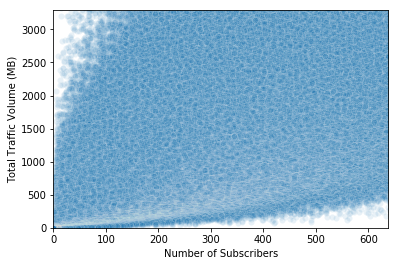

In [28]:
sns.scatterplot('Number of Subscribers','Total Traffic Volume (MB)',data=dla,alpha=0.1)
_=plt.xlim([0,np.percentile(dla['Number of Subscribers'].values,95)])
_=plt.ylim([0,np.percentile(dla['Total Traffic Volume (MB)'].values,95)])

<h2>Join the two data</h2>

In [12]:
dca.set_index(['Latitude','Longitude'],inplace=True)
dla.set_index(['Latitude','Longitude'],inplace=True)

In [13]:
df = dca.join(dla,how='inner',lsuffix='_dca',rsuffix='_dla')

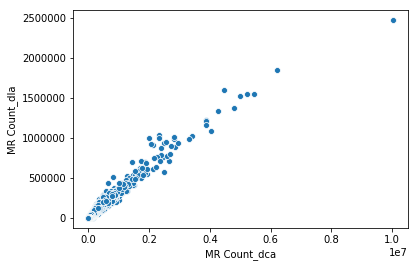

In [23]:
sns.scatterplot('MR Count_dca','MR Count_dla',data=df)

for MR data -> choose MR count from dla data

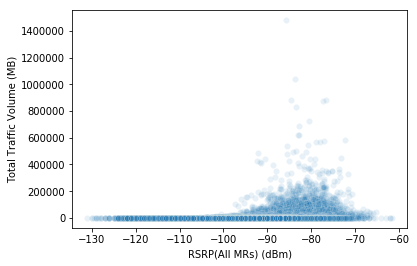

In [33]:
sns.scatterplot('RSRP(All MRs) (dBm)','Total Traffic Volume (MB)',data=df,alpha=0.1)

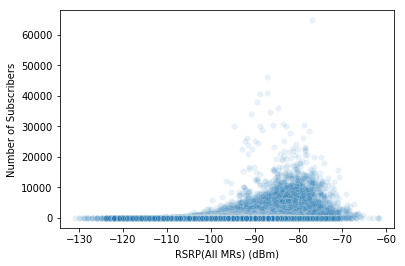

In [34]:
sns.scatterplot('RSRP(All MRs) (dBm)','Number of Subscribers',data=df,alpha=0.1)

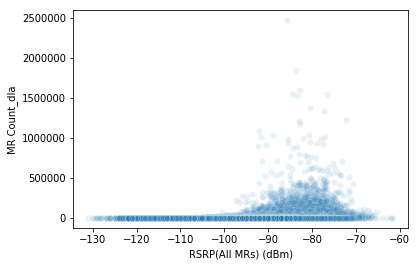

In [35]:
sns.scatterplot('RSRP(All MRs) (dBm)','MR Count_dla',data=df,alpha=0.1)

<h2>Using Coverage x Traffic data for the traffic estimation!</h2>

dividing the rsrp into range!

In [14]:
bins = pd.IntervalIndex.from_tuples([(-135,-125),(-125,-115),(-115,-105),(-105,-95),(-95,-85),(-85,-75),(-75,-65),(-65,-55)])
df['suppress traffic bin'] = pd.cut(df['RSRP(All MRs) (dBm)'],bins=bins,labels=['(-135,-125)','(-125,-115)','(-115,-105)','(-105,-95)','(-95,-85)','(-85,-75)','(-75,-65)','(-65,-55)'],include_lowest=True)

In [15]:
df = df[['RSRP(All MRs) (dBm)','Total Traffic Volume (MB)','suppress traffic bin']]

In [14]:
df.head()

RSRP(All MRs) (dBm)  Total Traffic Volume (MB)  \
Latitude  Longitude                                                    
13.461036 100.858384               -103.0                      0.040   
13.461486 100.848189                -95.0                      0.006   
          100.851897               -104.0                      0.000   
          100.863018                -83.5                      0.766   
13.461935 100.864408                -94.0                      0.000   

                     suppress traffic bin  
Latitude  Longitude                        
13.461036 100.858384          (-105, -95]  
13.461486 100.848189          (-105, -95]  
          100.851897          (-105, -95]  
          100.863018           (-85, -75]  
13.461935 100.864408           (-95, -85]

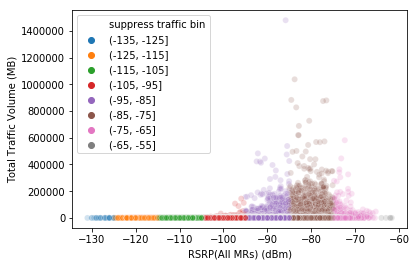

In [16]:
sns.scatterplot('RSRP(All MRs) (dBm)','Total Traffic Volume (MB)',data=df,alpha=0.2,hue='suppress traffic bin')

In [20]:
from scipy import stats
traff_target = df[df['suppress traffic bin']==bins[5]]['Total Traffic Volume (MB)'].values
df_low_cov = []
for idx in range(4):
    sub_df = df[df['suppress traffic bin']==bins[idx]]
    traff = sub_df['Total Traffic Volume (MB)'].values
    pct_t = stats.rankdata(traff, 'min')/len(traff)*100
    est_traff = np.percentile(traff_target,pct_t)
    sub_df['pct'] = pct_t
    sub_df['est_traff'] = est_traff
    df_low_cov.append(sub_df)

/Users/witchapong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/witchapong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [23]:
# concat all the estimated traffic together
df_low_all = df_low_cov[0]
for i in range(1,len(df_low_cov)):
    df_low_all = pd.concat([df_low_all,df_low_cov[i]],axis=0)

(2625, 5)
(120051, 5)
(1117912, 5)


In [3]:
import fiona
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
pa = fiona.open("../files/shape files/RNC_PA_region.shp")

pa_poly = [Polygon(item['geometry']['coordinates'][0]) for item in pa]

In [29]:
df_low_all.reset_index(inplace=True)

In [30]:
from tqdm import tqdm
tqdm.pandas()

def map_coor2cid(x):
    point = Point(x['Longitude'],x['Latitude'])
    for i,pa in enumerate(pa_poly):
        if pa.contains(point):
            return i
        
df_low_all['pa_id'] = df_low_all.progress_apply(map_coor2cid,axis=1)

100%|██████████| 1117912/1117912 [39:49<00:00, 467.80it/s] 


In [5]:
# calculate pa area
import pyproj
from functools import partial
from shapely.ops import transform
from shapely.geometry import shape

def cal_pa_area(x):
    geom = Polygon(pa_poly[x])
    s = shape(geom)
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
                   pyproj.Proj(init='epsg:3857'))

    s_new = transform(proj, s)

    return transform(proj, s).area

In [38]:
df_low_all['traffic_gain'] = df_low_all['est_traff'] - df_low_all['Total Traffic Volume (MB)']

pa_sum_df = pd.DataFrame(df_low_all.groupby('pa_id')['traffic_gain'].sum()).reset_index()

pa_sum_df['pa_id'] = pa_sum_df['pa_id'].astype(int)

pa_sum_df['pa_area'] = pa_sum_df['pa_id'].apply(cal_pa_area)

pa_sum_df['traffic gain/area (MB/m^2)'] = pa_sum_df['traffic_gain']/pa_sum_df['pa_area']

In [63]:
pa_sum_df.to_csv('../out/cov_291118.csv')

In [4]:
pa_sum_df = pd.read_csv('../out/cov_291118.csv')

In [6]:
pred_traff = pa_sum_df['traffic_gain'].values

import numpy as np
norm_pred_traff = (pred_traff - np.min(pred_traff))/(np.max(pred_traff)-np.min(pred_traff))

lng_list = []
lat_list = []
alpha_list = []
for i,pa_id in enumerate(pa_sum_df['pa_id']):
    lng=[]
    lat=[]
    for coor in pa[pa_id]['geometry']['coordinates'][0]:
        lng.append(coor[0])
        lat.append(coor[1])
    lng_list.append(lng)
    lat_list.append(lat)
    alpha_list.append(norm_pred_traff[i])

from bokeh.io import output_file,show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

source = ColumnDataSource(data = dict(
    pa_id = pa_sum_df['pa_id'].values,
    lng = lng_list,
    lat = lat_list,
    al = alpha_list,
    traff = pred_traff
))
plot = figure(plot_width=1000,title='predicted traffic gain(MB) from coverage improvement of each PA(Problem Area)')
plot.patches('lng','lat',alpha='al',source=source)

hover = HoverTool(tooltips=[('pa id', '@pa_id'),('predicted traffic gain (MB)', '@traff')])
plot.add_tools(hover)

output_file('../out/pa.html')
show(plot)

In [28]:
pa_sum_df.drop('Unnamed: 0',axis=1,inplace=True)

In [29]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Table(
    header=dict(values=list(pa_sum_df.columns),
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[pa_sum_df[col] for col in pa_sum_df.columns],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))

data = [trace] 
py.iplot(data, filename = 'PA summary table')

In [26]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create traces
trace0 = go.Scatter(
    x = pa_sum_df['traffic_gain'].values,
    y = pa_sum_df['traffic gain/area (MB/m^2)'].values,
    mode = 'markers',
    name = 'PA ID',
    text = pa_sum_df['pa_id']
)
trace1 = go.Scatter(
    x = [np.min(pa_sum_df['traffic_gain'].values),np.max(pa_sum_df['traffic_gain'].values)],
    y = [np.median(pa_sum_df['traffic gain/area (MB/m^2)'].values),np.median(pa_sum_df['traffic gain/area (MB/m^2)'].values)],
    mode = 'lines',
    line = dict(color = 'red')
)
trace2 = go.Scatter(
    x = [np.median(pa_sum_df['traffic_gain'].values),np.median(pa_sum_df['traffic_gain'].values)],
    y = [np.min(pa_sum_df['traffic gain/area (MB/m^2)'].values),np.max(pa_sum_df['traffic gain/area (MB/m^2)'].values)],
    mode = 'lines',
    line = dict(color = 'red')
)

data = [trace0, trace1, trace2]

layout= go.Layout(
    title= 'PA total traffic gain and traffic gain per area estimation',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Total traffic gain (MB)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Traffic gain per area (MB/m^2)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig= go.Figure(data=data, layout=layout)
py.iplot(fig,filename='PA total traffic gain and traffic gain per area estimation')